In [12]:
import pandas as pd

In [34]:
df = pd.read_csv('openml_phpmlDSTj.csv')

In [35]:
df.head()

,climbRate,Altitude,RollRate,curRoll,diffClb,diffDiffClb,Se
0,2.0,-50,-0.0048,-0.001,0.2,0.0,-0.001
1,6.5,-40,-0.0010,-0.009,0.2,0.0,0.003
2,-5.9,-10,-0.0033,-0.004,-0.1,0.0,-0.001
3,-6.2,-30,-0.0022,-0.011,0.1,0.0,-0.002
4,-0.2,-40,0.0059,-0.005,0.1,0.0,0.001


## Preprocessing danych

In [36]:
y = df[['Se']]
x = df.drop(columns=['Se'],axis=1,inplace=False)

In [37]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
x[['diffDiffClb']] = le.fit_transform(np.array(x[['diffDiffClb']]).ravel())
x[['diffClb']] = le.fit_transform(np.array(x[['diffClb']]).ravel())

In [38]:
x.head()

,climbRate,Altitude,RollRate,curRoll,diffClb,diffDiffClb
0,2.0,-50,-0.0048,-0.001,10,3
1,6.5,-40,-0.0010,-0.009,10,3
2,-5.9,-10,-0.0033,-0.004,7,3
3,-6.2,-30,-0.0022,-0.011,9,3
4,-0.2,-40,0.0059,-0.005,9,3


## Testy dla dwóch czarnych skrzynek na danych przed transformacją

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x.values, y , test_size = 0.1, random_state=0)

In [46]:
from xgboost import XGBRegressor
model_1 = XGBRegressor()
model_1.fit(X_train, np.array(y_train).ravel())

from sklearn.ensemble import RandomForestRegressor
model_2 = RandomForestRegressor(n_estimators=100)
model_2.fit(X_train, np.array(y_train).ravel())

from sklearn.metrics import mean_squared_error
print('MSE XGBoost: '+'%4.8f' % (mean_squared_error(y_test, model_1.predict(X_test))))
print('MSE Random Forest: '+'%4.8f' % (mean_squared_error(y_test, model_2.predict(X_test))))

MSE XGBoost: 0.00000180
MSE Random Forest: 0.00000190


In [47]:
import ruptures as rpt
import matplotlib.pyplot as plt

def pd_plot(model, features, feature_index, penalty):
    '''
    features - pandas DF
    '''    
    colnames = list(features.columns)
    features_values = features.values

    
    # Ceteris Paribus lines for all observations and PD-plot
    sorted_features = np.sort(features_values[:,feature_index])
    all_proba = []
    for j in range(features_values.shape[0]):
        x_to_predict = np.tile(features_values[j],(len(sorted_features),1))
        x_to_predict[:,feature_index] = sorted_features
        y = model.predict(x_to_predict)
        all_proba.append(y)
        if(len(features) < 1000):
            plt.plot(sorted_features,y, color = '0.75', zorder = 5)
    if(len(features) < 1000):
        plt.scatter(features_values[:,feature_index], model.predict(features_values.tolist()), c = 'black', s = 15, zorder = 10)
    plt.plot(sorted_features, np.mean(all_proba, axis = 0), color = 'black',linewidth = 5 , zorder = 15, label = 'PD plot')
    
    # Breakpoints detection
    algo = rpt.Pelt(model="l1").fit(np.mean(all_proba, axis = 0))
    result = algo.predict(pen=penalty)
    breakpoints = []
    for i in range(len(result)-1):
        plt.axvline(sorted_features[result[i]-1], color = 'red', linestyle = ':', markersize = 10, zorder = 10)
        breakpoints.append(sorted_features[result[i]-1])
    plt.show()
    
    return breakpoints
    

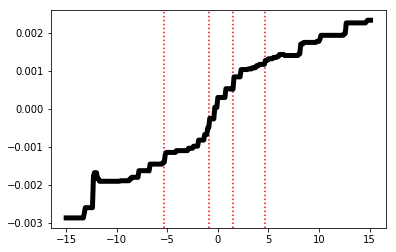

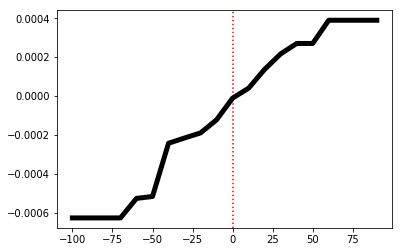

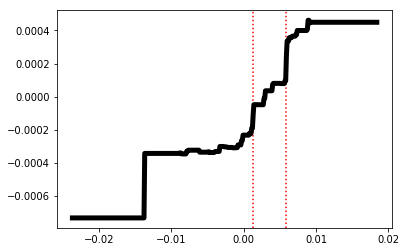

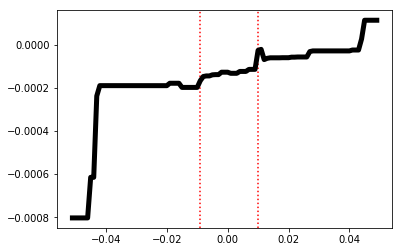

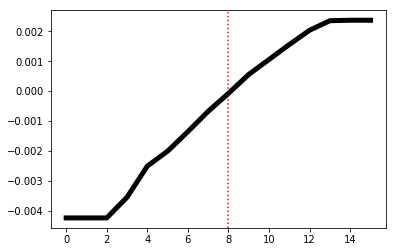

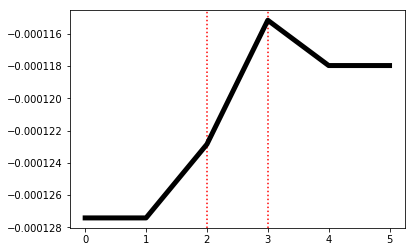

In [48]:
breakpoints_0 = pd_plot(model_1, x, 0, 0.3)
breakpoints_1 = pd_plot(model_1, x, 1, 0.5)
breakpoints_2 = pd_plot(model_1, x, 2, 0.1)
breakpoints_3 = pd_plot(model_1, x, 3, 0.05)
breakpoints_4 = pd_plot(model_1, x, 4, 2)
breakpoints_5 = pd_plot(model_1, x, 5, 0.002)

In [49]:
def transform_data(features, feature_index, breakpoints):
    colnames = features.columns
    
    # Category 0
    mask = features[colnames[feature_index]] < breakpoints[0]
    features.loc[mask, colnames[feature_index]] = 0
    
    # Category 1-(n-1)
    if len(breakpoints) > 2:
        for i in range(len(breakpoints)-1):
            mask = (features[colnames[feature_index]] >= breakpoints[i]) & (features[colnames[feature_index]] < breakpoints[i+1])
            features.loc[mask, colnames[feature_index]] = i + 1
     
    # Category n
    mask = features[colnames[feature_index]] >= breakpoints[-1]
    features.loc[mask, colnames[feature_index]] = len(breakpoints)

    return features

In [50]:
x_no_transformed = x.copy()

x = transform_data(x, 0, breakpoints_0)
x = transform_data(x, 2, breakpoints_2)
x = transform_data(x, 3, breakpoints_3)
x = transform_data(x, 4, breakpoints_4)
x = transform_data(x, 5, breakpoints_5)
x_transformed = x

## Testy dla 3 grup modeli

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_no_transformed.values, y , test_size = 0.1, random_state=0)
X_t_train, X_t_test, y_t_train, y_t_test = train_test_split(x_transformed.values, y , test_size = 0.1, random_state=0)

In [52]:
from sklearn.metrics import mean_squared_error

### Regresja liniowa

In [53]:
from sklearn.linear_model import LinearRegression
model_linear = LinearRegression()

model_linear.fit(X_train, y_train)
print('LM raw data: '+'%4.8f' % (mean_squared_error(y_test,model_linear.predict(X_test))))
model_linear.fit(X_t_train, y_t_train)
print('LM transformed data: '+'%4.8f' % (mean_squared_error(y_test,model_linear.predict(X_test))))

LM raw data: 0.00000187
LM transformed data: 0.00023197


### XGBoost

In [54]:
from xgboost import XGBRegressor
model_xgb = XGBRegressor()

model_xgb.fit(X_train, y_train)
print('XGBoost raw data: '+'%4.8f' % (mean_squared_error(y_test,model_xgb.predict(X_test))))
model_xgb.fit(X_t_train, y_t_train)
print('XGBoost transformed data: '+'%4.8f' % (mean_squared_error(y_test,model_xgb.predict(X_test))))

XGBoost raw data: 0.00000180
XGBoost transformed data: 0.00000504


### Random Forest

In [57]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators=100)

model_rf.fit(X_train, np.array(y_train).ravel())
print('Random Forest raw data: '+'%4.8f' % (mean_squared_error(y_test,model_rf.predict(X_test))))
model_xgb.fit(X_t_train, y_t_train)
print('Random Forest transformed data: '+'%4.8f' % (mean_squared_error(y_test,model_rf.predict(X_test))))

Random Forest raw data: 0.00000195
Random Forest transformed data: 0.00000195


## Wnioski

Zestaw danych, które wybrałem, jest uzyskany z systemu sterowania lotkami samolotu F16. Niestety nie sią do końca opisane, więc atrybuty i zmienne celu pozostają tajemnicą.

Poniżej tabelka z wynikami średniego błędu kwadratowego dla poszczególnych modeli.

| Model | MSE |
|---------------------------------|-----|
| **Linear Model** (raw data) |$0.00000187$|
| **Linear Model** (transformed data) | $0.00023197$ |
| **Random Forest** (raw data) | $0.00000180$|
| **Random Forest** (transformed data) |$0.00000504$|
| **XGBoost** (raw data) | $0.00000195$ |
| **XGBoost** (transformed data) | $0.00000504$ |

Można zauważyć, że wszystkie modele są bardzo skuteczne. Nawet regresja liniowa, na nieprzetransformowanych danych, daje błąd rzędu zero. Wydaje się, że może to być powodem tego, że transformacja zmiennych nie polepsza znacznie wyników.